![Lancaster University](https://www.lancaster.ac.uk/media/lancaster-university/content-assets/images/fst/logos/SCC-Logo.svg)

# SCC.454: Large Scale Platforms for AI and Data Analysis
## Lab 2: Introduction to Apache Spark

**Duration:** 2 hours

**Learning Objectives:**
- Understand what Apache Spark is and why it's used for big data processing
- Learn to set up and configure Spark in Google Colab
- Master the fundamentals of RDDs (Resilient Distributed Datasets)
- Work with Spark DataFrames and the DataFrame API
- Execute SQL queries using Spark SQL
- Apply Spark to real-world datasets

## Table of Contents

1. **Part 1: Introduction to Apache Spark** (20 minutes)
   - What is Apache Spark?
   - Spark Architecture Overview
   - Setting up Spark in Google Colab
   - Creating Your First SparkSession

2. **Part 2: RDDs - Resilient Distributed Datasets** (30 minutes)
   - Understanding RDDs
   - Creating RDDs
   - Transformations and Actions
   - Lazy Evaluation
   - Word Count Example

3. **Part 3: Spark DataFrames** (40 minutes)
   - Introduction to DataFrames
   - Loading Data from Various Sources
   - DataFrame Operations
   - Working with Real-World Data: Global Temperature Dataset
   - Data Aggregation and Grouping

4. **Part 4: Spark SQL** (20 minutes)
   - Introduction to Spark SQL
   - Creating Temporary Views
   - Writing SQL Queries
   - Combining DataFrame API and SQL

5. **Part 5: Practical Exercises** (10 minutes)
   - Exercise 1: Movie Ratings Analysis
   - Exercise 2: E-commerce Sales Analysis
   - Challenge Exercise

---
# Part 1: Introduction to Apache Spark
---

## 1.1 What is Apache Spark?

Apache Spark is a unified analytics engine for large-scale data processing. Originally developed at UC Berkeley's AMPLab in 2009, Spark was designed to overcome the limitations of the Hadoop MapReduce model while maintaining its benefits.

**Key Features of Spark:**

- **Speed**: Spark can be up to 100x faster than Hadoop MapReduce for certain applications, thanks to in-memory computing
- **Ease of Use**: Provides high-level APIs in Python, Java, Scala, and R
- **Generality**: Supports SQL queries, streaming data, machine learning, and graph processing
- **Runs Everywhere**: Can run on Hadoop, Apache Mesos, Kubernetes, standalone, or in the cloud

**When to use Spark:**
- Processing large datasets (gigabytes to petabytes)
- Iterative algorithms (machine learning)
- Interactive data analysis
- Stream processing
- ETL (Extract, Transform, Load) operations

## 1.2 Spark Architecture Overview

Spark follows a master-worker architecture:

```
┌─────────────────────────────────────────────────────┐
│                   Driver Program                     │
│  ┌─────────────────────────────────────────────┐    │
│  │              SparkContext                    │    │
│  └─────────────────────────────────────────────┘    │
└───────────────────────┬─────────────────────────────┘
                        │
        ┌───────────────┼───────────────┐
        │               │               │
        ▼               ▼               ▼
┌───────────────┐ ┌───────────────┐ ┌───────────────┐
│   Worker 1    │ │   Worker 2    │ │   Worker N    │
│  ┌─────────┐  │ │  ┌─────────┐  │ │  ┌─────────┐  │
│  │Executor │  │ │  │Executor │  │ │  │Executor │  │
│  │ Tasks   │  │ │  │ Tasks   │  │ │  │ Tasks   │  │
│  └─────────┘  │ │  └─────────┘  │ │  └─────────┘  │
└───────────────┘ └───────────────┘ └───────────────┘
```

**Components:**
- **Driver Program**: The main program that creates the SparkContext and coordinates the execution
- **SparkContext**: The entry point to Spark functionality, connects to the cluster
- **Cluster Manager**: Allocates resources across applications (YARN, Mesos, Kubernetes, or standalone)
- **Executors**: Processes that run on worker nodes, execute tasks and store data

## 1.3 Setting up Spark in Google Colab

Google Colab doesn't have Spark pre-installed, so we need to set it up manually. Run the cell below to install PySpark and configure the Java environment.

If you are running it on a different system make sure you give the correct JAVA_HOME

Do not worry about the pip error you see here

In [2]:
# Install PySpark
# !pip install pyspark==3.5.0 -q

# # Install Java (Spark requires Java)
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Set Java environment variable
import os
print(os.environ["JAVA_HOME"]) 

print("PySpark and Java installed successfully!")

E:\Program Files\Java\jdk-25.0.2
PySpark and Java installed successfully!


## 1.4 Creating Your First SparkSession

The `SparkSession` is the entry point to Spark functionality in Spark 2.0+. It provides a unified interface to work with DataFrames, SQL, and streaming.

In earlier versions of Spark (1.x), you needed separate contexts:
- `SparkContext` for RDDs
- `SQLContext` for DataFrames and SQL
- `HiveContext` for Hive integration

`SparkSession` combines all of these into a single, unified entry point.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.appName("Testing PySpark Example").getOrCreate()

In [2]:
sc = spark.sparkContext

In [13]:
# from pyspark.sql import SparkSession
from pyspark import SparkConf

# Create a SparkSession
spark = SparkSession.builder \
    .appName("SCC454-SparkIntro") \
    .config("spark.driver.memory", "4g") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Get the underlying SparkContext
sc = spark.sparkContext

print(f"Spark Version: {spark.version}")
print(f"Application Name: {spark.sparkContext.appName}")
print(f"Master: {spark.sparkContext.master}")

Spark Version: 4.1.1
Application Name: SCC454-SparkIntro
Master: local[*]


In [1]:
print("maaz")

maaz


You can display the SparkSession object to see its configuration:

In [14]:
spark

**Understanding Local Mode:**

When you see `Master: local[*]`, it means Spark is running in local mode using all available CPU cores. This is perfect for learning and development. In production, you would connect to a cluster manager like YARN or Kubernetes.

The `local[N]` notation means:
- `local`: Run Spark locally with one thread
- `local[2]`: Run Spark locally with 2 worker threads
- `local[*]`: Run Spark locally with as many threads as CPU cores

---
# Part 2: RDDs - Resilient Distributed Datasets
---

## 2.1 Understanding RDDs

RDD (Resilient Distributed Dataset) is the fundamental data structure of Spark. It's an immutable, distributed collection of objects that can be processed in parallel.

**Key Properties of RDDs:**

- **Resilient**: Can recover from node failures through lineage
- **Distributed**: Data is distributed across multiple nodes in the cluster
- **Dataset**: Collection of partitioned data with primitive values or custom objects

**RDD Characteristics:**
- Immutable: Once created, the data in an RDD cannot be changed
- Lazily Evaluated: Transformations are not executed until an action is called
- Cacheable: Can be cached in memory for faster access

## 2.2 Creating RDDs

There are two main ways to create RDDs:
1. **Parallelizing an existing collection** in your driver program
2. **Loading data from external storage** (files, databases, etc.)

In [11]:
from pyspark.sql import SparkSession
sc.stop()

In [3]:
# Method 1: Parallelize a Python collection
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
numbers_rdd = sc.parallelize(numbers)

print(f"Type: {type(numbers_rdd)}")
print(f"Number of partitions: {numbers_rdd.getNumPartitions()}")
print(f"First 5 elements: {numbers_rdd.take(5)}")

Type: <class 'pyspark.core.rdd.RDD'>
Number of partitions: 2
First 5 elements: [1, 2, 3, 4, 5]


In [4]:
# Method 1b: Parallelize with specified number of partitions
numbers_rdd_4part = sc.parallelize(numbers, 4)
print(f"Number of partitions: {numbers_rdd_4part.getNumPartitions()}")

# View the partitions
print("\nData in each partition:")
print(numbers_rdd_4part.glom().collect())

Number of partitions: 4

Data in each partition:
[[1, 2], [3, 4], [5, 6], [7, 8, 9, 10]]


In [ ]:
# Method 2: Create RDD from a text file
# First, let's create a sample text file

sample_text = """Apache Spark is a unified analytics engine for large-scale data processing.
It provides high-level APIs in Java, Scala, Python and R.
Spark powers a stack of libraries including SQL and DataFrames.
It also includes MLlib for machine learning and GraphX for graph processing.
Spark can run on Hadoop, Apache Mesos, Kubernetes, standalone, or in the cloud."""

with open("spark_intro.txt", "w") as f:
    f.write(sample_text)

# Load the text file as an RDD
text_rdd = sc.textFile("spark_intro.txt")
print(f"Number of lines: {text_rdd.count()}")
print("\nFirst 3 lines:")
for line in text_rdd.take(3):
    print(f"  - {line}")

## 2.3 Transformations and Actions

RDD operations are divided into two categories:

**Transformations**: Create a new RDD from an existing one. They are *lazy* - they don't execute until an action is called.

| Transformation | Description |
|----------------|-------------|
| `map(func)` | Apply function to each element |
| `filter(func)` | Keep elements where function returns true |
| `flatMap(func)` | Map then flatten the results |
| `distinct()` | Remove duplicates |
| `reduceByKey(func)` | Aggregate values by key |
| `groupByKey()` | Group values by key |
| `sortBy(func)` | Sort RDD elements |

**Actions**: Return a value to the driver program. They *trigger* the execution of transformations.

| Action | Description |
|--------|-------------|
| `collect()` | Return all elements as a list |
| `count()` | Return the number of elements |
| `first()` | Return the first element |
| `take(n)` | Return first n elements |
| `reduce(func)` | Aggregate elements using a function |
| `saveAsTextFile(path)` | Write elements to a text file |

In [5]:
# Transformation Examples

numbers = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# map: Apply a function to each element
squared = numbers.map(lambda x: x ** 2)
print(f"Original: {numbers.collect()}")
print(f"Squared:  {squared.collect()}")

# filter: Keep only elements that match a condition
evens = numbers.filter(lambda x: x % 2 == 0)
print(f"Evens:    {evens.collect()}")

# Chaining transformations
even_squares = numbers.filter(lambda x: x % 2 == 0).map(lambda x: x ** 2)
print(f"Even squares: {even_squares.collect()}")

Original: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Squared:  [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
Evens:    [2, 4, 6, 8, 10]
Even squares: [4, 16, 36, 64, 100]


In [ ]:
# flatMap: Map then flatten
sentences = sc.parallelize(["Hello World", "Apache Spark", "Big Data"])

# map vs flatMap
words_map = sentences.map(lambda s: s.split())
words_flatmap = sentences.flatMap(lambda s: s.split())

print(f"Using map:     {words_map.collect()}")
print(f"Using flatMap: {words_flatmap.collect()}")

In [ ]:
# Action Examples

numbers = sc.parallelize([1, 2, 3, 4, 5])

print(f"collect(): {numbers.collect()}")
print(f"count():   {numbers.count()}")
print(f"first():   {numbers.first()}")
print(f"take(3):   {numbers.take(3)}")
print(f"sum():     {numbers.sum()}")
print(f"mean():    {numbers.mean()}")
print(f"max():     {numbers.max()}")
print(f"min():     {numbers.min()}")

# reduce: Aggregate elements
total = numbers.reduce(lambda a, b: a + b)
print(f"reduce(+): {total}")

## 2.4 Lazy Evaluation

Spark transformations are *lazy* - they don't execute immediately. Instead, Spark builds up a *lineage graph* (DAG - Directed Acyclic Graph) of transformations. The actual computation only happens when an action is called.

**Benefits of Lazy Evaluation:**
- Allows Spark to optimize the execution plan
- Reduces unnecessary computations
- Enables fault tolerance through lineage

In [ ]:
# Demonstrating Lazy Evaluation
import time

# Create an RDD and apply transformations
print("Creating RDD and transformations...")
start = time.time()

large_rdd = sc.parallelize(range(1000000))
transformed = large_rdd.map(lambda x: x * 2).filter(lambda x: x % 4 == 0)

print(f"Time to define transformations: {time.time() - start:.4f} seconds")
print(f"Transformations are defined but NOT executed yet!")
print(f"Type of 'transformed': {type(transformed)}")

# Now trigger execution with an action
print("\nCalling count() action...")
start = time.time()
result = transformed.count()
print(f"Time to execute: {time.time() - start:.4f} seconds")
print(f"Count: {result}")

## 2.5 Word Count Example - The "Hello World" of Big Data

Word Count is the classic MapReduce example. Let's implement it using Spark RDDs.

In [6]:
# Create a sample text
text = """Spark is fast and general purpose cluster computing system
Spark provides high level APIs in Java Scala Python and R
Spark supports general computation graphs for data analysis
Spark has rich set of higher level tools including Spark SQL
Spark SQL provides support for structured data processing"""

# Save to file
with open("wordcount_input.txt", "w") as f:
    f.write(text)

# Word Count using RDDs - Step by Step
lines = sc.textFile("wordcount_input.txt")

# Step 1: Split each line into words
words = lines.flatMap(lambda line: line.lower().split())
print("Step 1 - Words:")
print(words.take(10))

# Step 2: Map each word to a (word, 1) pair
word_pairs = words.map(lambda word: (word, 1))
print("\nStep 2 - Word pairs:")
print(word_pairs.take(10))

# Step 3: Reduce by key - sum up counts for each word
word_counts = word_pairs.reduceByKey(lambda a, b: a + b)
print("\nStep 3 - Word counts:")
print(word_counts.take(10))

# Step 4: Sort by count (descending)
sorted_counts = word_counts.sortBy(lambda x: -x[1])
print("\nTop 10 words:")
for word, count in sorted_counts.take(10):
    print(f"  {word}: {count}")

Step 1 - Words:
['spark', 'is', 'fast', 'and', 'general', 'purpose', 'cluster', 'computing', 'system', 'spark']

Step 2 - Word pairs:
[('spark', 1), ('is', 1), ('fast', 1), ('and', 1), ('general', 1), ('purpose', 1), ('cluster', 1), ('computing', 1), ('system', 1), ('spark', 1)]

Step 3 - Word counts:
[('fast', 1), ('and', 2), ('general', 2), ('computing', 1), ('high', 1), ('level', 2), ('java', 1), ('python', 1), ('supports', 1), ('for', 2)]

Top 10 words:
  spark: 6
  and: 2
  general: 2
  level: 2
  for: 2
  provides: 2
  data: 2
  sql: 2
  fast: 1
  computing: 1


In [23]:
# Word Count - Concise Version (one-liner)

word_counts_concise = sc.textFile("wordcount_input.txt") \
    .flatMap(lambda line: line.lower().split()) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: -x[1])

print("Word counts (concise version):")
for word, count in word_counts_concise.take(10):
    print(f"  {word}: {count}")

Word counts (concise version):
  spark: 6
  and: 2
  general: 2
  level: 2
  for: 2
  provides: 2
  data: 2
  sql: 2
  fast: 1
  computing: 1


---
# Part 3: Spark DataFrames
---

## 3.1 Introduction to DataFrames

A DataFrame is a distributed collection of data organized into named columns, similar to a table in a relational database or a DataFrame in pandas. DataFrames are built on top of RDDs but provide:

- **Schema**: Named columns with data types
- **Optimized Execution**: Catalyst optimizer for query optimization
- **Familiar API**: SQL-like operations

**DataFrames vs RDDs:**

| Feature | RDD | DataFrame |
|---------|-----|----------|
| Schema | No schema | Named columns with types |
| Optimization | No automatic optimization | Catalyst optimizer |
| Ease of use | Low-level API | High-level, SQL-like API |
| Performance | Good | Better (optimized) |
| Data types | Any Python object | Structured data types |

## 3.2 Creating DataFrames

There are multiple ways to create DataFrames in Spark.

In [7]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import Row

# Method 1: From a list of tuples
data = [
    ("Alice", 28, "Data Scientist", 75000),
    ("Bob", 35, "Software Engineer", 85000),
    ("Charlie", 32, "Data Analyst", 65000),
    ("Diana", 29, "ML Engineer", 90000),
    ("Eve", 41, "Data Scientist", 95000)
]
columns = ["name", "age", "role", "salary"]

df = spark.createDataFrame(data, columns)
df.show()

+-------+---+-----------------+------+
|   name|age|             role|salary|
+-------+---+-----------------+------+
|  Alice| 28|   Data Scientist| 75000|
|    Bob| 35|Software Engineer| 85000|
|Charlie| 32|     Data Analyst| 65000|
|  Diana| 29|      ML Engineer| 90000|
|    Eve| 41|   Data Scientist| 95000|
+-------+---+-----------------+------+



In [8]:
# Method 2: With explicit schema
schema = StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("role", StringType(), True),
    StructField("salary", IntegerType(), True)
])

df_with_schema = spark.createDataFrame(data, schema)
df_with_schema.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- role: string (nullable = true)
 |-- salary: integer (nullable = true)



In [11]:
df_with_schema.show()

+-------+---+-----------------+------+
|   name|age|             role|salary|
+-------+---+-----------------+------+
|  Alice| 28|   Data Scientist| 75000|
|    Bob| 35|Software Engineer| 85000|
|Charlie| 32|     Data Analyst| 65000|
|  Diana| 29|      ML Engineer| 90000|
|    Eve| 41|   Data Scientist| 95000|
+-------+---+-----------------+------+



In [12]:
# Method 3: From a pandas DataFrame
import pandas as pd

pandas_df = pd.DataFrame({
    "city": ["London", "Manchester", "Birmingham", "Leeds", "Glasgow"],
    "population": [8982000, 547627, 1141816, 793139, 626410],
    "country": ["England", "England", "England", "England", "Scotland"]
})

spark_df = spark.createDataFrame(pandas_df)
spark_df.show()

+----------+----------+--------+
|      city|population| country|
+----------+----------+--------+
|    London|   8982000| England|
|Manchester|    547627| England|
|Birmingham|   1141816| England|
|     Leeds|    793139| England|
|   Glasgow|    626410|Scotland|
+----------+----------+--------+



In [13]:
# Method 4: From Row objects
row_data = [
    Row(product="Laptop", price=999.99, quantity=50),
    Row(product="Mouse", price=29.99, quantity=200),
    Row(product="Keyboard", price=79.99, quantity=150)
]

df_rows = spark.createDataFrame(row_data)
df_rows.show()

+--------+------+--------+
| product| price|quantity|
+--------+------+--------+
|  Laptop|999.99|      50|
|   Mouse| 29.99|     200|
|Keyboard| 79.99|     150|
+--------+------+--------+



## 3.3 Loading Data from External Sources

Spark can read data from various formats including CSV, JSON, Parquet, and more. Let's download a real-world dataset to work with.

In [24]:
# Download the Global Land Temperatures dataset from NASA GISS
# This is the official GISTEMP v4 dataset (Global Land-Ocean Temperature Index)

!wget -q https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv -O global_temp.csv

# Preview the file
!head -15 global_temp.csv

Land-Ocean: Global Means
Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1880,-.19,-.25,-.10,-.17,-.11,-.22,-.19,-.11,-.15,-.24,-.23,-.18,-.18,***,***,-.13,-.17,-.21
1881,-.20,-.15,.03,.04,.05,-.19,.00,-.04,-.16,-.22,-.19,-.07,-.09,-.10,-.18,.04,-.08,-.19
1882,.15,.13,.04,-.17,-.15,-.23,-.17,-.08,-.15,-.24,-.17,-.36,-.12,-.09,.07,-.09,-.16,-.19
1883,-.30,-.37,-.13,-.18,-.17,-.08,-.07,-.14,-.21,-.11,-.23,-.11,-.18,-.20,-.34,-.16,-.10,-.19
1884,-.13,-.08,-.36,-.41,-.34,-.36,-.30,-.27,-.27,-.25,-.34,-.31,-.29,-.27,-.11,-.37,-.31,-.29
1885,-.59,-.34,-.27,-.42,-.46,-.44,-.34,-.32,-.29,-.24,-.24,-.11,-.34,-.35,-.41,-.38,-.37,-.26
1886,-.44,-.51,-.43,-.29,-.25,-.35,-.19,-.31,-.24,-.28,-.28,-.25,-.32,-.31,-.36,-.32,-.28,-.27
1887,-.73,-.58,-.36,-.36,-.31,-.25,-.26,-.36,-.26,-.36,-.26,-.34,-.37,-.36,-.52,-.34,-.29,-.29
1888,-.34,-.36,-.41,-.21,-.22,-.17,-.11,-.16,-.12,.01,.02,-.05,-.18,-.20,-.35,-.28,-.15,-.03
1889,-.10,.16,.06,.09,-.01,-.10,-.07,-.20,-.24,-.26,-.34

In [ ]:
# Simpler approach: use pandas to clean, then convert to Spark
import pandas as pd
from pyspark.sql.functions import col, lit, explode, array, struct

# Read with pandas, skip the first row
pdf = pd.read_csv("global_temp.csv", skiprows=1)
print("Pandas columns:", pdf.columns.tolist())
print(pdf.head())

# Convert to Spark DataFrame
temp_df_raw = spark.createDataFrame(pdf)

print("\nSpark DataFrame:")
temp_df_raw.show(5)
print("\nSchema:")
temp_df_raw.printSchema()

# Now transform to long format
month_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

temp_df = temp_df_raw.select(
    col("Year"),
    explode(array([struct(lit(i+1).alias("Month"), col(m).cast("double").alias("Mean"))
                   for i, m in enumerate(month_cols)])).alias("data")
).select(
    col("Year").cast("int").alias("Year"),
    col("data.Month").alias("Month"),
    col("data.Mean").alias("Mean")
).filter(col("Mean").isNotNull())

# Add a Source column for consistency
temp_df = temp_df.withColumn("Source", lit("GISTEMP"))

print("\nTransformed data (long format):")
temp_df.show(10)

print("\nSchema:")
temp_df.printSchema()

print(f"\nTotal records: {temp_df.count()}")

## 3.4 DataFrame Operations

DataFrames support a rich set of operations for data manipulation and analysis.

In [ ]:
from pyspark.sql.functions import col, year, month, avg, max, min, count, round

# Select columns
print("Select specific columns:")
temp_df.select("Year", "Month", "Mean").show(5)

# Select with expressions - convert to Fahrenheit
print("\nSelect with expressions (add Fahrenheit):")
temp_df.select(
    col("Year"),
    col("Month"),
    col("Mean"),
    round(col("Mean") * 1.8 + 32, 2).alias("Mean_Fahrenheit")
).show(5)

In [ ]:
# Filter rows
print("Filter: Temperatures above 0.5°C anomaly:")
temp_df.filter(col("Mean") > 0.5).show(5)

# Multiple conditions
print("\nFilter: Year 2020 or later with mean > 0.8:")
temp_df.filter(
    (col("Year") >= 2020) & (col("Mean") > 0.8)
).show(10)

In [ ]:
# Add new columns with withColumn
from pyspark.sql.functions import when

# The data already has Year and Month columns, let's add derived columns
temp_df_enhanced = temp_df \
    .withColumn("Mean_F", round(col("Mean") * 1.8 + 32, 2)) \
    .withColumn("Decade", (col("Year") / 10).cast("int") * 10) \
    .withColumn("Season",
                when(col("Month").isin(12, 1, 2), "Winter")
                .when(col("Month").isin(3, 4, 5), "Spring")
                .when(col("Month").isin(6, 7, 8), "Summer")
                .otherwise("Autumn"))

temp_df_enhanced.show(10)

In [ ]:
# Sorting
print("Sorted by Mean (descending) - Warmest temperature anomalies:")
temp_df_enhanced.orderBy(col("Mean").desc()).show(10)

print("\nSorted by Mean (ascending) - Coldest temperature anomalies:")
temp_df_enhanced.orderBy(col("Mean").asc()).show(10)

## 3.5 Data Aggregation and Grouping

Aggregation operations are essential for data analysis. Spark provides powerful groupBy and aggregation functions.

In [ ]:
# Basic aggregations
print("Overall statistics:")
temp_df_enhanced.agg(
    count("*").alias("total_records"),
    round(avg("Mean"), 4).alias("avg_temp"),
    round(max("Mean"), 4).alias("max_temp"),
    round(min("Mean"), 4).alias("min_temp")
).show()

In [ ]:
# Group by Year and calculate average temperature
yearly_avg = temp_df_enhanced \
    .groupBy("Year") \
    .agg(
        round(avg("Mean"), 4).alias("Avg_Temp"),
        round(max("Mean"), 4).alias("Max_Temp"),
        round(min("Mean"), 4).alias("Min_Temp")
    ) \
    .orderBy("Year")

print("Yearly temperature statistics (GISTEMP):")
yearly_avg.show(20)

In [ ]:
# Compare by decade
decade_comparison = temp_df_enhanced \
    .groupBy("Decade") \
    .agg(
        count("*").alias("Record_Count"),
        round(avg("Mean"), 4).alias("Avg_Temp"),
        round(max("Mean"), 4).alias("Max_Temp"),
        round(min("Mean"), 4).alias("Min_Temp")
    ) \
    .orderBy("Decade")

print("Temperature anomalies by Decade:")
decade_comparison.show()

In [ ]:
# Visualize the trends using matplotlib
import matplotlib.pyplot as plt

# Convert to pandas for plotting
yearly_pandas = yearly_avg.toPandas()

plt.figure(figsize=(14, 6))
plt.plot(yearly_pandas["Year"], yearly_pandas["Avg_Temp"], marker='o', markersize=3, linewidth=1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Temperature Anomaly (°C)", fontsize=12)
plt.title("Global Temperature Anomaly by Year (NASA GISTEMP v4)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='1951-1980 Baseline')
plt.legend()
plt.tight_layout()
plt.show()

## 3.6 Working with Missing Data

In [ ]:
from pyspark.sql.functions import when, isnan, isnull

# Create a DataFrame with missing values
data_with_nulls = [
    ("A", 25, 50000.0),
    ("B", None, 60000.0),
    ("C", 35, None),
    ("D", None, None),
    ("E", 45, 80000.0)
]

df_nulls = spark.createDataFrame(data_with_nulls, ["name", "age", "salary"])
print("DataFrame with null values:")
df_nulls.show()

# Count nulls per column
print("Null counts per column:")
df_nulls.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_nulls.columns
]).show()

In [ ]:
# Drop rows with any null values
print("Drop rows with any null:")
df_nulls.na.drop().show()

# Drop rows where specific columns are null
print("Drop rows where age is null:")
df_nulls.na.drop(subset=["age"]).show()

# Fill null values
print("Fill nulls with 0:")
df_nulls.na.fill(0).show()

# Fill with different values per column
print("Fill with specific values per column:")
df_nulls.na.fill({"age": 30, "salary": 50000.0}).show()

---
# Part 4: Spark SQL
---

## 4.1 Introduction to Spark SQL

Spark SQL allows you to query structured data using SQL syntax. This is particularly useful if you're already familiar with SQL or need to integrate with SQL-based tools.

**Advantages of Spark SQL:**
- Familiar SQL syntax for data analysts
- Automatic query optimization via Catalyst
- Integration with Hive and other data sources
- Mix SQL with DataFrame operations

## 4.2 Creating Temporary Views

To use SQL queries, you first need to register your DataFrame as a temporary view.

In [14]:
# Register the temperature DataFrame as a temporary view
temp_df_enhanced.createOrReplaceTempView("temperatures")

print("Temporary view 'temperatures' created successfully!")
print("\nAvailable columns:")
print(temp_df_enhanced.columns)

NameError: name 'temp_df_enhanced' is not defined

## 4.3 Writing SQL Queries

Once you have a temporary view, you can run SQL queries using `spark.sql()`.

In [ ]:
# Basic SELECT query
result = spark.sql("""
    SELECT Year, Month, Mean, Mean_F, Season
    FROM temperatures
    LIMIT 10
""")
result.show()

In [ ]:
# Filtering with WHERE
high_temps = spark.sql("""
    SELECT Year, Month, Mean, Season, Decade
    FROM temperatures
    WHERE Mean > 1.0
    ORDER BY Mean DESC
    LIMIT 15
""")

print("Months with temperature anomaly > 1.0°C:")
high_temps.show()

In [ ]:
# Aggregation with GROUP BY
yearly_stats = spark.sql("""
    SELECT
        Year,
        ROUND(AVG(Mean), 4) as avg_temp,
        ROUND(MAX(Mean), 4) as max_temp,
        ROUND(MIN(Mean), 4) as min_temp,
        COUNT(*) as num_records
    FROM temperatures
    GROUP BY Year
    HAVING AVG(Mean) > 0.5
    ORDER BY avg_temp DESC
""")

print("Years with average temperature anomaly > 0.5°C:")
yearly_stats.show(20)

In [ ]:
# Aggregation by decade
warmest_per_decade = spark.sql("""
    SELECT
        Decade,
        ROUND(AVG(Mean), 4) as Avg_Temp,
        COUNT(*) as Num_Records,
        MIN(Year) as First_Year,
        MAX(Year) as Last_Year
    FROM temperatures
    GROUP BY Decade
    ORDER BY Decade
""")

print("Average temperature anomaly by decade:")
warmest_per_decade.show()

## 4.4 Combining DataFrame API and SQL

You can seamlessly switch between DataFrame API and SQL operations.

In [ ]:
# Start with SQL, continue with DataFrame API
recent_years = spark.sql("""
    SELECT *
    FROM temperatures
    WHERE Year >= 2000
""")

# Continue with DataFrame operations
monthly_pattern = recent_years \
    .groupBy("Month") \
    .agg(
        round(avg("Mean"), 4).alias("Avg_Temp"),
        count("*").alias("Count")
    ) \
    .orderBy("Month")

print("Monthly temperature patterns (2000+):")
monthly_pattern.show(12)

In [ ]:
# The result of DataFrame operations can be registered as a new view
monthly_pattern.createOrReplaceTempView("monthly_patterns")

# Query the new view
warmest_months = spark.sql("""
    SELECT
        Month,
        Avg_Temp,
        CASE
            WHEN Month IN (12, 1, 2) THEN 'Winter'
            WHEN Month IN (3, 4, 5) THEN 'Spring'
            WHEN Month IN (6, 7, 8) THEN 'Summer'
            ELSE 'Autumn'
        END as Season
    FROM monthly_patterns
    ORDER BY Avg_Temp DESC
""")

warmest_months.show()

---
# Part 5: Practical Exercises
---

Now it's your turn to apply what you've learned! Complete the following exercises using the datasets provided.

## Exercise 1: Movie Ratings Analysis

Let's work with a real dataset! We'll use the MovieLens 100K dataset, which contains 100,000 movie ratings.

In [15]:
# Download MovieLens 100K dataset
!wget -q https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q -o ml-100k.zip

# Load the ratings data
ratings_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)
])

ratings_df = spark.read \
    .option("delimiter", "\t") \
    .schema(ratings_schema) \
    .csv("ml-100k/u.data")

# Load movie titles
movies_df = spark.read \
    .option("delimiter", "|") \
    .csv("ml-100k/u.item") \
    .select(
        col("_c0").cast("int").alias("movie_id"),
        col("_c1").alias("title"),
        col("_c2").alias("release_date")
    )

print("Ratings DataFrame:")
ratings_df.show(5)

print("\nMovies DataFrame:")
movies_df.show(5)

# Register as views for SQL
ratings_df.createOrReplaceTempView("ratings")
movies_df.createOrReplaceTempView("movies")

Ratings DataFrame:
+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
+-------+--------+------+---------+
only showing top 5 rows

Movies DataFrame:
+--------+-----------------+------------+
|movie_id|            title|release_date|
+--------+-----------------+------------+
|       1| Toy Story (1995)| 01-Jan-1995|
|       2| GoldenEye (1995)| 01-Jan-1995|
|       3|Four Rooms (1995)| 01-Jan-1995|
|       4|Get Shorty (1995)| 01-Jan-1995|
|       5|   Copycat (1995)| 01-Jan-1995|
+--------+-----------------+------------+
only showing top 5 rows


### Task 1.1: Basic Statistics

Calculate and display:
1. Total number of ratings
2. Number of unique users
3. Number of unique movies
4. Average rating across all movies

In [17]:
# Your code here
# movies_df.createOrReplaceTempView()("movies")

total_ratings = spark.sql("select count(rating) from Ratings")

total_ratings.show()

+-------------+
|count(rating)|
+-------------+
|       100000|
+-------------+



### Task 1.2: Rating Distribution

Show the distribution of ratings (how many ratings of each value 1-5). Order by rating value.

In [20]:
# Your code here
rating_distribution = spark.sql("select count(rating) as distribution, rating from Ratings group by rating")
rating_distribution.show()


+------------+------+
|distribution|rating|
+------------+------+
|        6110|     1|
|       27145|     3|
|       21201|     5|
|       34174|     4|
|       11370|     2|
+------------+------+



### Task 1.3: Top Rated Movies

Find the top 10 highest-rated movies that have at least 100 ratings. Join with the movies table to show the movie title.

**Hint:** You'll need to:
1. Group ratings by movie_id
2. Calculate average rating and count
3. Filter for movies with ≥100 ratings
4. Join with movies_df to get titles
5. Order by average rating (descending)

In [23]:
movies_df.show(1)
ratings_df.show(2)

+--------+----------------+------------+
|movie_id|           title|release_date|
+--------+----------------+------------+
|       1|Toy Story (1995)| 01-Jan-1995|
+--------+----------------+------------+
only showing top 1 row
+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
+-------+--------+------+---------+
only showing top 2 rows


In [51]:
# Your code here
highest_rated_movies = spark.sql("select A.movie_id,count(A.rating) as rating_counts,Round(avg(A.rating),2), B.title from ratings A Join movies B on A.movie_id = B.movie_id group by A.movie_id,B.title having  count(A.rating) > 100 order by avg(A.rating) desc, count(A.rating) asc  Limit 20")
highest_rated_movies.show()

+--------+-------------+---------------------+--------------------+
|movie_id|rating_counts|round(avg(rating), 2)|               title|
+--------+-------------+---------------------+--------------------+
|     408|          112|                 4.49|Close Shave, A (1...|
|     318|          298|                 4.47|Schindler's List ...|
|     169|          118|                 4.47|Wrong Trousers, T...|
|     483|          243|                 4.46|   Casablanca (1942)|
|      64|          283|                 4.45|Shawshank Redempt...|
|     603|          209|                 4.39|  Rear Window (1954)|
|      12|          267|                 4.39|Usual Suspects, T...|
|      50|          583|                 4.36|    Star Wars (1977)|
|     178|          125|                 4.34| 12 Angry Men (1957)|
|     134|          198|                 4.29| Citizen Kane (1941)|
|     427|          219|                 4.29|To Kill a Mocking...|
|     357|          264|                 4.29|On

In [47]:
from pyspark.sql.functions import avg, round, col, count  # <--- Add col and count here

# Step 1: Group ratings by movie_id and calculate stats
movie_stats = ratings_df \
    .groupBy("movie_id") \
    .agg(
        round(avg("rating"), 2).alias("avg_rating"),
        count("*").alias("num_ratings")
    )

# Step 2: Filter for movies with >= 100 ratings
popular_movies = movie_stats.filter(col("num_ratings") >= 100)

# Step 3: Join with movies_df to get titles
top_rated = popular_movies \
    .join(movies_df, "movie_id") \
    .select("title", "avg_rating", "num_ratings") \
    .orderBy(col("avg_rating").desc()) \
    .limit(10)

print("Top 10 Highest-Rated Movies (with >= 100 ratings):")
top_rated.show(truncate=False)

Top 10 Highest-Rated Movies (with >= 100 ratings):
+--------------------------------------+----------+-----------+
|title                                 |avg_rating|num_ratings|
+--------------------------------------+----------+-----------+
|Close Shave, A (1995)                 |4.49      |112        |
|Schindler's List (1993)               |4.47      |298        |
|Wrong Trousers, The (1993)            |4.47      |118        |
|Casablanca (1942)                     |4.46      |243        |
|Shawshank Redemption, The (1994)      |4.45      |283        |
|Usual Suspects, The (1995)            |4.39      |267        |
|Rear Window (1954)                    |4.39      |209        |
|Star Wars (1977)                      |4.36      |583        |
|12 Angry Men (1957)                   |4.34      |125        |
|One Flew Over the Cuckoo's Nest (1975)|4.29      |264        |
+--------------------------------------+----------+-----------+



### Task 1.4: SQL Challenge

Write a SQL query to find the top 5 users who have rated the most movies. Show their user_id, number of ratings, and average rating they give.

In [53]:
ratings_df.show(1)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
+-------+--------+------+---------+
only showing top 1 row


In [55]:
# Your SQL query here
result = spark.sql("select user_id, count(rating),round(avg(rating),2) from ratings group by user_id order by count(rating) desc limit 5")
result.show()

+-------+-------------+---------------------+
|user_id|count(rating)|round(avg(rating), 2)|
+-------+-------------+---------------------+
|    405|          737|                 1.83|
|    655|          685|                 2.91|
|     13|          636|                  3.1|
|    450|          540|                 3.86|
|    276|          518|                 3.47|
+-------+-------------+---------------------+



## Exercise 2: E-commerce Sales Analysis

Now let's work with an e-commerce dataset to practice more complex operations.

In [56]:
# Create a synthetic e-commerce dataset
import random
from datetime import datetime, timedelta
from builtins import round as python_round

# Set seed for reproducibility
random.seed(42)

# Generate data
categories = ["Electronics", "Clothing", "Home & Garden", "Books", "Sports"]
products = {
    "Electronics": ["Laptop", "Phone", "Tablet", "Headphones", "Camera"],
    "Clothing": ["T-Shirt", "Jeans", "Jacket", "Shoes", "Hat"],
    "Home & Garden": ["Chair", "Table", "Lamp", "Plant", "Vase"],
    "Books": ["Fiction", "Non-Fiction", "Technical", "Children", "Comics"],
    "Sports": ["Football", "Tennis Racket", "Yoga Mat", "Dumbbells", "Bicycle"]
}
regions = ["North", "South", "East", "West", "Central"]

sales_data = []
base_date = datetime(2024, 1, 1)

for i in range(5000):
    category = random.choice(categories)
    product = random.choice(products[category])
    date = base_date + timedelta(days=random.randint(0, 364))
    quantity = random.randint(1, 10)
    base_price = random.uniform(10, 500)
    discount = random.choice([0.0, 0.0, 0.0, 0.1, 0.15, 0.2, 0.25])  # Use 0.0 instead of 0
    price = python_round(base_price * (1 - discount), 2)
    total = python_round(price * quantity, 2)

    sales_data.append((
        i + 1,
        date.strftime("%Y-%m-%d"),
        category,
        product,
        random.choice(regions),
        float(quantity),      # Ensure float
        float(price),         # Ensure float
        float(total),         # Ensure float
        float(discount)       # Ensure float
    ))

# Create DataFrame
sales_columns = ["order_id", "order_date", "category", "product", "region",
                 "quantity", "unit_price", "total", "discount"]
sales_df = spark.createDataFrame(sales_data, sales_columns)

# Add month column
from pyspark.sql.functions import substring
sales_df = sales_df.withColumn("month", substring("order_date", 1, 7))

print("E-commerce Sales Data:")
sales_df.show(10)

print(f"\nTotal records: {sales_df.count()}")

# Register as view
sales_df.createOrReplaceTempView("sales")

E-commerce Sales Data:
+--------+----------+-------------+-----------+-------+--------+----------+-------+--------+-------+
|order_id|order_date|     category|    product| region|quantity|unit_price|  total|discount|  month|
+--------+----------+-------------+-----------+-------+--------+----------+-------+--------+-------+
|       1|2024-05-20|  Electronics|     Laptop|  North|     4.0|      95.5|  382.0|     0.2|2024-05|
|       2|2024-10-29|       Sports|   Football|  South|     7.0|     25.57| 178.99|     0.0|2024-10|
|       3|2024-11-04|     Clothing|        Hat|Central|     1.0|    228.01| 228.01|     0.2|2024-11|
|       4|2024-08-17|        Books|Non-Fiction|  North|    10.0|    109.74| 1097.4|    0.25|2024-08|
|       5|2024-06-23|     Clothing|      Shoes|   East|     5.0|     64.64|  323.2|    0.25|2024-06|
|       6|2024-07-13|  Electronics|     Laptop|Central|     2.0|     185.9|  371.8|     0.0|2024-07|
|       7|2024-08-23|Home & Garden|      Chair|  North|     9.0|    

### Task 2.1: Sales by Category

Calculate total sales, number of orders, and average order value for each category. Order by total sales (descending).

In [65]:
# Your code here
from pyspark.sql.functions import sum
sales_by_category = sales_df.groupBy("category").agg(
    count("*").alias("total_orders"),
    round(avg(col("unit_price")*col("quantity")),2).alias("avg_order_value"),
    sum(col("total")).alias("total sales")
    ).orderBy(col("total sales").desc())
sales_by_category.show()

+-------------+------------+---------------+------------------+
|     category|total_orders|avg_order_value|       total sales|
+-------------+------------+---------------+------------------+
|        Books|        1077|        1189.38|1280962.1900000009|
|  Electronics|         999|        1242.77|1241530.8499999996|
|       Sports|         983|        1251.61|1230332.5799999994|
|Home & Garden|         985|         1246.9|        1228191.76|
|     Clothing|         956|        1262.82|1207258.1100000008|
+-------------+------------+---------------+------------------+



In [64]:
# Solution using DataFrame API
sales_by_category = sales_df \
    .groupBy("category") \
    .agg(
        round(sum("total"), 2).alias("total_sales"),
        count("*").alias("num_orders"),
        round(avg("total"), 2).alias("avg_order_value")
    ) \
    .orderBy(col("total_sales").desc())
print("Sales by Category:")
sales_by_category.show()

Sales by Category:
+-------------+-----------+----------+---------------+
|     category|total_sales|num_orders|avg_order_value|
+-------------+-----------+----------+---------------+
|        Books| 1280962.19|      1077|        1189.38|
|  Electronics| 1241530.85|       999|        1242.77|
|       Sports| 1230332.58|       983|        1251.61|
|Home & Garden| 1228191.76|       985|         1246.9|
|     Clothing| 1207258.11|       956|        1262.82|
+-------------+-----------+----------+---------------+



### Task 2.2: Monthly Trend Analysis

Analyze monthly sales trends:
1. Calculate total sales per month
2. Show results ordered by month
3. Create a simple visualization of the trend

In [76]:
# Your code here
total_sales = spark.sql("select round(sum(total),2) as total_sales, Month(month) from sales group by Month(month) order by Month(month) asc")
total_sales.show()

+-----------+------------+
|total_sales|month(month)|
+-----------+------------+
|  546784.36|           1|
|  556427.92|           2|
|  566005.45|           3|
|  450215.59|           4|
|  438542.28|           5|
|  522098.24|           6|
|  574690.09|           7|
|  468752.26|           8|
|  473621.92|           9|
|  511336.98|          10|
|  561343.08|          11|
|  518457.32|          12|
+-----------+------------+



In [69]:
import matplotlib.pyplot as plt
# Solution: Calculate monthly sales
monthly_sales = sales_df \
    .groupBy("month") \
    .agg(
        round(sum("total"), 2).alias("total_sales"),
        count("*").alias("num_orders")
    ) \
    .orderBy("month")
print("Monthly Sales Trends:")
monthly_sales.show(12)

Monthly Sales Trends:
+-------+-----------+----------+
|  month|total_sales|num_orders|
+-------+-----------+----------+
|2024-01|  546784.36|       425|
|2024-02|  556427.92|       419|
|2024-03|  566005.45|       466|
|2024-04|  450215.59|       370|
|2024-05|  438542.28|       391|
|2024-06|  522098.24|       405|
|2024-07|  574690.09|       483|
|2024-08|  468752.26|       402|
|2024-09|  473621.92|       371|
|2024-10|  511336.98|       420|
|2024-11|  561343.08|       421|
|2024-12|  518457.32|       427|
+-------+-----------+----------+



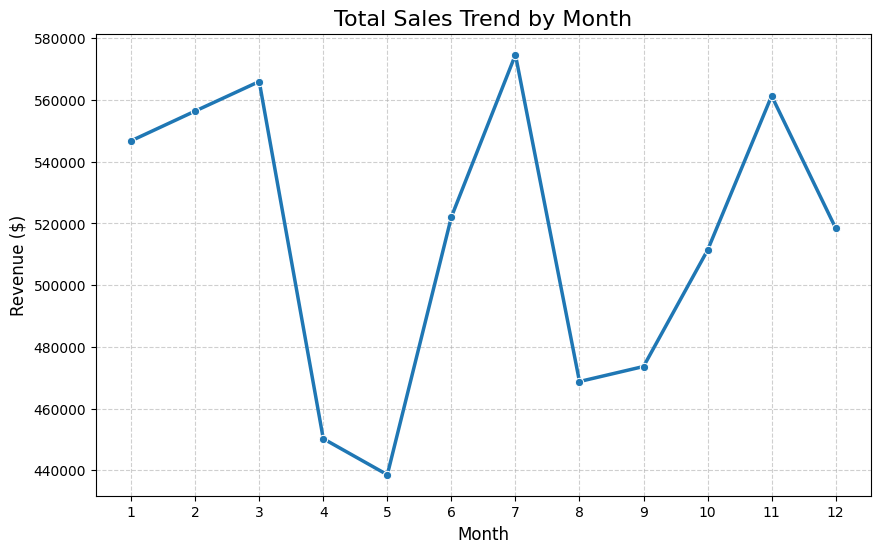

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert to pandas (if you haven't already)
df_plot = total_sales.toPandas()

# 2. IMPORTANT: Sort by month so the line goes in order
# If month is an integer (1-12), this ensures Jan comes before Feb
df_plot = df_plot.sort_values("month(month)")

# 3. Create the trend graph
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x="month(month)", y="total_sales", marker="o", linewidth=2.5)

# 4. Make it look professional
plt.title("Total Sales Trend by Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Revenue ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, 13)) # Ensure all months show up on the axis

plt.show()

### Task 2.3: Regional Performance

Using SQL, find:
1. Total sales by region
2. The best-selling product in each region

**Hint:** For part 2, you might need a subquery or window function.

In [87]:
# First, make sure your 'sales' table is registered
sales_df.createOrReplaceTempView("sales")

best_selling_query = """
WITH ProductSales AS (
    SELECT 
        region, 
        product, 
        SUM(total) as total
    FROM sales
    GROUP BY region, product
),
RankedProducts AS (
    SELECT 
        region, 
        product, 
        total,
        ROW_NUMBER() OVER(PARTITION BY region ORDER BY total DESC) as rank
    FROM ProductSales
)
SELECT region, product, total
FROM RankedProducts
WHERE rank = 1
ORDER BY total DESC
"""

best_selling_product_by_region = spark.sql(best_selling_query)
best_selling_product_by_region.show()

+-------+--------+------------------+
| region| product|             total|
+-------+--------+------------------+
|Central|   Jeans| 73124.56000000001|
|  South|  Tablet| 68728.84999999999|
|  North|Yoga Mat|          66859.27|
|   East| Bicycle|65078.259999999995|
|   West|   Chair|          64040.78|
+-------+--------+------------------+



### Task 2.4: Discount Impact Analysis

Analyze the relationship between discounts and sales:
1. Group orders by discount level (0%, 10%, 15%, 20%, 25%)
2. Calculate average order value and total quantity for each discount level
3. What patterns do you observe?

In [88]:
# Your code here

from pyspark.sql.functions import when, concat, lit
# Solution: Analyze discount impact
discount_analysis = sales_df \
    .withColumn("discount_level",
        when(col("discount") == 0.0, "0%")
        .when(col("discount") == 0.1, "10%")
        .when(col("discount") == 0.15, "15%")
        .when(col("discount") == 0.2, "20%")
        .when(col("discount") == 0.25, "25%")
        .otherwise("Other")
    ) \
    .groupBy("discount_level") \
    .agg(
        count("*").alias("num_orders"),
        round(avg("total"), 2).alias("avg_order_value"),
        round(sum("quantity"), 0).alias("total_quantity"),
        round(sum("total"), 2).alias("total_sales"),
        round(avg("quantity"), 2).alias("avg_quantity_per_order")
    ) \
    .orderBy("discount_level")
print("Discount Impact Analysis:")
discount_analysis.show()


Discount Impact Analysis:
+--------------+----------+---------------+--------------+-----------+----------------------+
|discount_level|num_orders|avg_order_value|total_quantity|total_sales|avg_quantity_per_order|
+--------------+----------+---------------+--------------+-----------+----------------------+
|            0%|      2092|        1378.33|       11429.0| 2883456.04|                  5.46|
|           10%|       732|        1219.71|        3899.0|  892827.28|                  5.33|
|           15%|       742|        1207.03|        4140.0|  895615.04|                  5.58|
|           20%|       738|         1065.3|        4033.0|   786191.8|                  5.46|
|           25%|       696|        1049.12|        3793.0|  730185.33|                  5.45|
+--------------+----------+---------------+--------------+-----------+----------------------+



## Challenge Exercise (Optional)

Combine what you've learned to complete this advanced analysis.

Using the sales data, create a comprehensive report that includes:

1. **Category Deep Dive**: For each category, find the month with highest sales
2. **Pareto Analysis**: Identify products that contribute to 80% of total sales
3. **Performance Metrics**: Calculate month-over-month growth rate for total sales

**Bonus**: Create visualizations for your findings.

In [ ]:
# Your code here - Challenge Exercise



---
# Cleanup
---

Always remember to stop your Spark session when you're done to release resources.

In [ ]:
# Stop the Spark session
spark.stop()
print("Spark session stopped.")

---
# Summary
---

In this lab, you learned:

1. **Apache Spark Fundamentals**
   - What Spark is and why it's used for big data processing
   - Spark's master-worker architecture
   - How to set up and configure Spark in Google Colab

2. **RDDs (Resilient Distributed Datasets)**
   - Creating RDDs from collections and files
   - Transformations vs Actions
   - Lazy evaluation and its benefits
   - Classic Word Count example

3. **Spark DataFrames**
   - Creating DataFrames from various sources
   - DataFrame operations: select, filter, withColumn
   - Aggregation and grouping
   - Handling missing data

4. **Spark SQL**
   - Creating temporary views
   - Writing SQL queries on DataFrames
   - Combining DataFrame API with SQL

5. **Practical Application**
   - Working with real-world datasets (Global Temperature, MovieLens)
   - Data analysis patterns and best practices

---
# Additional Resources
---

- Apache Spark Documentation: https://spark.apache.org/docs/latest/
- PySpark API Reference: https://spark.apache.org/docs/latest/api/python/
- Spark SQL Guide: https://spark.apache.org/docs/latest/sql-programming-guide.html
- Databricks Learning: https://www.databricks.com/learn
- Spark: The Definitive Guide (Book): https://www.oreilly.com/library/view/spark-the-definitive/9781491912201/